In [1]:
import numpy as np
import pandas as pd
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
classes = {'zero':0, 'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8, 'nine':9, 'ten':10, 'eleven':11, 'twelve':12, 'thirteen':13, 'fourteen':14, 'fifteen':15, 'sixteen':16, 'draw':17}
cols = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7}

In [3]:
class ChessDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        df = pd.read_table(path, header=None, delimiter=',')
        df[0] = df[0].map(cols)
        df[2] = df[2].map(cols)
        df[4] = df[4].map(cols)
        df[6] = df[6].map(classes)
        data = df.values
        self.X = data[:,: -1]
        self.y = data[:,  -1]
    def __getitem__(self, index: int):
        return (self.X[index], self.y[index])
    def __len__(self):
        return len(self.y)

In [4]:
class ChessModel(torch.nn.Module):
    def __init__(self, n_feat, n_hid1, n_hid2, n_labl):
        super(ChessModel, self).__init__()
        self.hid1 = torch.nn.Linear(n_feat, n_hid1)
        self.hid2 = torch.nn.Linear(n_hid1, n_hid2)
        self.oupt = torch.nn.Linear(n_hid2, n_labl)

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.hid2.weight)
        torch.nn.init.zeros_(self.hid2.bias)
        torch.nn.init.xavier_uniform_(self.oupt.weight)
        torch.nn.init.zeros_(self.oupt.bias)

        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
    def forward(self, z):
        z = self.hid1(z)
        z = torch.nn.Tanh()(z)
        z = self.hid2(z)
        z = torch.nn.Tanh()(z)
        z = self.oupt(z)
        return z
    def accuracy(self, predicts, labels):
        equals = (predicts == labels.view(*predicts.shape))
        acc = torch.mean(equals.type(torch.FloatTensor)).item()
        return acc
    def loss(self, outputs, labels):
        return self.criterion(outputs, labels)
    def train(self, inputs, labels):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.loss(outputs, labels)
        loss.backward()
        model.optimizer.step()
        return loss
    def evaluate(self, inputs, labels):
        accuracy = self.accuracy(self.predict(inputs), labels)
        loss = self.loss(self.forward(inputs), labels).item()
        return accuracy, loss
    def predict(self, inputs):
        outputs = self.forward(inputs)
        max_index = torch.argmax(outputs, dim=1)
        return max_index

In [5]:
train_data = ChessDataset('train.data')
train_loader = torch.utils.data.DataLoader(train_data, 64, True)
val_data = ChessDataset('val.data')
val_loader = torch.utils.data.DataLoader(val_data, 64, True)

model = ChessModel(6, 108, 108, 18)

In [6]:
model.load_state_dict(torch.load("model.pt"))

num_epochs = 20

running_loss = 0
train_losses = []
val_losses = []
val_accuracy = []
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        loss = model.train(inputs, labels)
        running_loss += loss.item()
        if i % len(train_loader) == len(train_loader) - 1:
            val_loss = 0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device).type(torch.FloatTensor), labels.to(device)
                    accuracy_, val_loss_ = model.evaluate(inputs, labels)
                    val_loss += val_loss_
                    accuracy += accuracy_
            print(f"[{epoch+1:3}/{num_epochs}, {i+1}]. Train loss: {running_loss/len(train_loader):.3f}, val loss: {val_loss/len(val_loader):.3f}, val accuracy: {accuracy/len(val_loader)};")
            train_losses.append(running_loss/len(train_loader))
            val_losses.append(val_loss/len(val_loader))
            val_accuracy.append(accuracy/len(val_loader))
            running_loss = 0

torch.save(model.state_dict(), "model.pt")

[  1/20, 395]. Train loss: 0.143, val loss: 0.597, val accuracy: 0.8233821256594225;
[  2/20, 395]. Train loss: 0.138, val loss: 0.617, val accuracy: 0.8147992112419822;
[  3/20, 395]. Train loss: 0.142, val loss: 0.643, val accuracy: 0.8077571256594225;
[  4/20, 395]. Train loss: 0.138, val loss: 0.598, val accuracy: 0.8279925855723295;
[  5/20, 395]. Train loss: 0.139, val loss: 0.605, val accuracy: 0.8188800080256029;
[  6/20, 395]. Train loss: 0.142, val loss: 0.639, val accuracy: 0.8152686818079515;
[  7/20, 395]. Train loss: 0.139, val loss: 0.649, val accuracy: 0.8184707246043466;
[  8/20, 395]. Train loss: 0.140, val loss: 0.640, val accuracy: 0.824802580204877;
[  9/20, 395]. Train loss: 0.135, val loss: 0.633, val accuracy: 0.8183503476056185;
[ 10/20, 395]. Train loss: 0.140, val loss: 0.619, val accuracy: 0.8254526203328912;
[ 11/20, 395]. Train loss: 0.136, val loss: 0.635, val accuracy: 0.816749326207421;
[ 12/20, 395]. Train loss: 0.138, val loss: 0.616, val accuracy: 0.

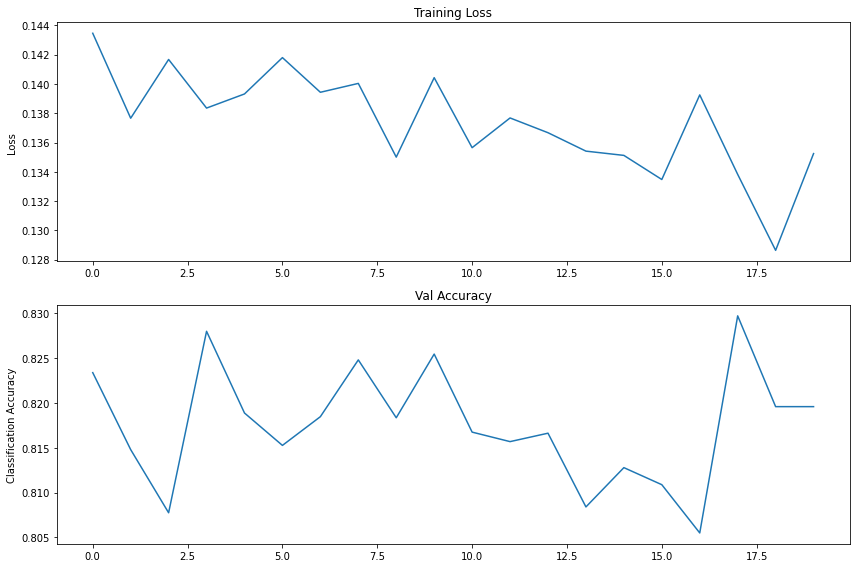

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_losses)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(val_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Val Accuracy')

plt.tight_layout()
plt.show()

<AxesSubplot:>

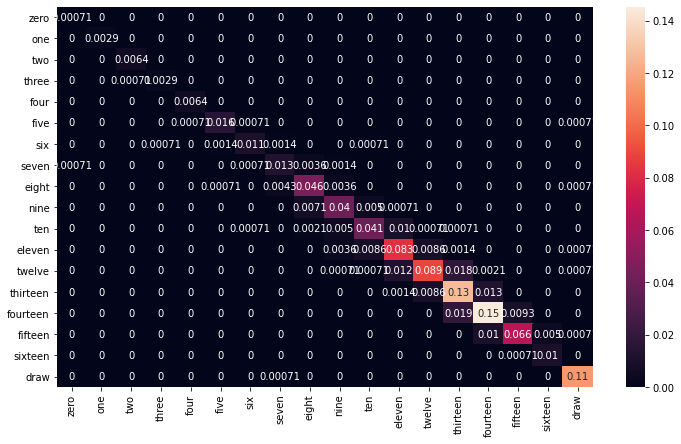

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []
for inputs, labels in val_loader:
        inputs, labels = inputs.to(device).type(torch.FloatTensor), labels.to(device)
        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)